# Data Import

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# data_path = ("C:\\Users\\EAFle\\U3S4_BW\\GitHub_Repo\\Kickstarter\\data-modeling-1\\KickstarterCleanedv3.csv")

# raw_df = pd.read_csv(data_path, index_col='idb

In [158]:
raw_df = pd.read_csv('KickstarterData.zip', index_col='id')

# Exploratory Data Analysis

In [137]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218361 entries, 1629235715 to 807310529
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         218361 non-null  int64  
 1   backers_count      218361 non-null  int64  
 2   blurb              218353 non-null  object 
 3   category           218361 non-null  object 
 4   country            218361 non-null  object 
 5   created_at         218361 non-null  object 
 6   deadline           218361 non-null  object 
 7   goal               218361 non-null  float64
 8   launched_at        218361 non-null  object 
 9   name               218361 non-null  object 
 10  pledged            218361 non-null  float64
 11  spotlight          218361 non-null  int64  
 12  staff_pick         218361 non-null  int64  
 13  state              218361 non-null  int64  
 14  state_changed_at   218361 non-null  object 
 15  usd_exchange_rate  218361 non-null  flo

In [4]:
from pandas_profiling import ProfileReport

In /home/prockwood/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/prockwood/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/prockwood/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/prockwood/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/prockwood/anaconda3/lib/python3.8/site-

In [6]:
profile = ProfileReport(raw_df, minimal=True)
profile.to_file(output_file="profile.html")

Summarize dataset:   0%|          | 0/30 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Dataframe Cleaning

In [159]:
# Applying the necessary data cleaning and featuring engineering
# in one wrangle function.

def wrangle(df):

    # Defining new reader friendly column names
    column_names = ['Kickstarter_id', 'Backers Count', 'Campaign Description', 'Primary Category', \
        'Country', 'Campaign Created', 'Deadline', 'Campaign Goal', 'Campaign Start', \
        'Product Name', 'Amount Pledged', 'Product Spotlight', 'Staff Pick', 'Status', \
        'Goal Reached Date', 'USD Exchange Rate', 'USD Pledged', 'Description Length', 'Goal in USD', \
        'Campaign Length', 'Subcategory']
    df.columns = column_names


    # Capitalizing the category and subcategory data points for an easier read
    df['Primary Category'] = df['Primary Category'].str.title()
    df['Subcategory'] = df['Subcategory'].str.title()


    # Converting date columns to datetime dtype
    date_columns = ['Campaign Created', 'Deadline', 'Campaign Start', 'Goal Reached Date']
    df[date_columns] = df[date_columns].apply(pd.to_datetime)


    # Dropping columns and rows not applicable to an American audience
    non_essential_columns = ['Kickstarter_id', 'USD Exchange Rate', 'USD Pledged', 'Goal in USD', 'Product Spotlight']
    df.drop(columns=non_essential_columns, axis=1, inplace=True)
    df.drop(df.loc[df['Country']!='US'].index, inplace=True)


    # Correcting country name with ISO country code name
    df['Country'] = df['Country'].replace('US', 'USA')
    df.drop(columns='Country', inplace=True)
    
    # Remove weird dict strings in Primary Category
    df['Primary Category'] = df['Primary Category'].apply(lambda x: re.findall(r"[a-zA-z]+", x)[0])

    # Filling absent subcategory values with primary category values
    # We don't want to discredit a product because it cannot qualify
    # For a granular subcategory
    df[['Primary Category', 'Subcategory']] = df[['Primary Category', 'Subcategory']].astype(str)
    df['Subcategory'].fillna(df['Primary Category'], inplace=True)


    # Dropping rows with no campaign description
    # As they may not be serious campaigns
    # This data may also provide future data leakage indicating campaign failure.
    df.dropna(axis=0, inplace=True)


    # Creating features to indicate goal and pledge amounts per day and per backer
    # These features can assist campaign success measurements
    df['Goal Amount Per Backer'] = round(df['Campaign Goal']/df['Backers Count'])
    df['Pledge Amount Per Backer'] = round(df['Amount Pledged']/df['Backers Count'])
    df['Goal Amount Per Day'] = round(df['Campaign Goal']/df['Campaign Length'])
    df['Pledge Amount Per Day'] = round(df['Amount Pledged']/df['Campaign Length'])


    # Creating data to quantify the time from campagin creation to start
    df['Campaign Launch Length'] = df['Campaign Start'].sub(df['Campaign Created'], axis=0)
    
    # Remove duplicate 'Product Name' rows
    df.drop_duplicates(subset=['Product Name'], keep='first', inplace=True)
    df.drop_duplicates(subset=['Campaign Description'], keep='first', inplace=True)

    return df

In [160]:
df = wrangle(raw_df)

df.head()

,Backers Count,Campaign Description,Primary Category,Campaign Created,Deadline,Campaign Goal,Campaign Start,Product Name,Amount Pledged,Staff Pick,Status,Goal Reached Date,Description Length,Campaign Length,Subcategory,Goal Amount Per Backer,Pledge Amount Per Backer,Goal Amount Per Day,Pledge Amount Per Day,Campaign Launch Length
id,,,,,,,,,,,,,,,,,,,,
1629235715,63,A Steve Lafler graphic novel,Comics,2020-08-27,2020-09-24,599.0,2020-09-01,1956 Book One: Sweet Sweet Little Ramona,1942.0,0,1,2020-09-24,5.0,23,Graphic Novels,10.0,31.0,26.0,84.0,5 days
1593905291,132,What happens when two drug-fueled lowlifes fin...,Comics,2017-01-16,2017-03-16,2000.0,2017-02-14,Modern Animals,3097.0,0,1,2017-03-16,20.0,30,Graphic Novels,15.0,23.0,67.0,103.0,29 days
1341470613,6,A pillow meant for two.,Crafts,2015-02-01,2015-03-05,500.0,2015-02-03,Couples Couch Pillow,211.0,0,0,2015-03-05,5.0,30,Diy,83.0,35.0,17.0,7.0,2 days
510157690,16,Professional conservation of the 1880's mural ...,Art,2018-10-24,2019-04-24,17000.0,2019-03-10,"Downtown Mural Restoration (Ann Arbor, MI)",1368.0,0,0,2019-04-24,18.0,45,Painting,1062.0,86.0,378.0,30.0,137 days
147824964,44,"We are trying to raise $2,500 for an art proje...",Art,2012-06-28,2013-04-05,2500.0,2013-02-04,The Trade Parade of Ecuador,2506.0,0,1,2013-04-05,14.0,60,Performance Art,57.0,57.0,42.0,42.0,221 days


In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131714 entries, 1629235715 to 2093445204
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype          
---  ------                    --------------   -----          
 0   Backers Count             131714 non-null  int64          
 1   Campaign Description      131714 non-null  object         
 2   Primary Category          131714 non-null  object         
 3   Campaign Created          131714 non-null  datetime64[ns] 
 4   Deadline                  131714 non-null  datetime64[ns] 
 5   Campaign Goal             131714 non-null  float64        
 6   Campaign Start            131714 non-null  datetime64[ns] 
 7   Product Name              131714 non-null  object         
 8   Amount Pledged            131714 non-null  float64        
 9   Product Spotlight         131714 non-null  int64          
 10  Staff Pick                131714 non-null  int64          
 11  Status                    131714 non-nu

In [127]:
df_sml = df[['Backers Count', 'Primary Category', 
            'Campaign Created', 
            'Staff Pick', 'Status', 'Description Length', 
            'Campaign Length', 'Subcategory']]

In [91]:
df_sml.head()

,Backers Count,Primary Category,Campaign Created,Product Spotlight,Staff Pick,Status,Description Length,Campaign Length,Subcategory
id,,,,,,,,,
1629235715,63,Comics,2020-08-27,1,0,1,5.0,23,Graphic Novels
1593905291,132,Comics,2017-01-16,1,0,1,20.0,30,Graphic Novels
1341470613,6,Crafts,2015-02-01,0,0,0,5.0,30,Diy
510157690,16,Art,2018-10-24,0,0,0,18.0,45,Painting
147824964,44,Art,2012-06-28,1,0,1,14.0,60,Performance Art


In [92]:
for col in df_sml.columns:
    print(df_sml[col].describe())
    print('\n', '--------------------------------------', '\n')

count    148206.000000
mean        167.920988
std        1049.392306
min           0.000000
25%           5.000000
50%          33.000000
75%         103.000000
max      105857.000000
Name: Backers Count, dtype: float64

 -------------------------------------- 

count     148206
unique        30
top        Music
freq       21576
Name: Primary Category, dtype: object

 -------------------------------------- 

count                  148206
unique                   4250
top       2014-07-08 00:00:00
freq                      476
first     2009-04-22 00:00:00
last      2021-05-10 00:00:00
Name: Campaign Created, dtype: object

 -------------------------------------- 

count    148206.000000
mean          0.612809
std           0.487110
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: Product Spotlight, dtype: float64

 -------------------------------------- 

count    148206.000000
mean          0.144259
std           

<ipython-input-92-5b73d4a3170e>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df_sml[col].describe())


## Feature Engineering


# Data Visualization


In [87]:
# Bar chart of primary category, subcategories, campaign length https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html

# Whisker plot of campaign goal, amount pledged, backers count https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html

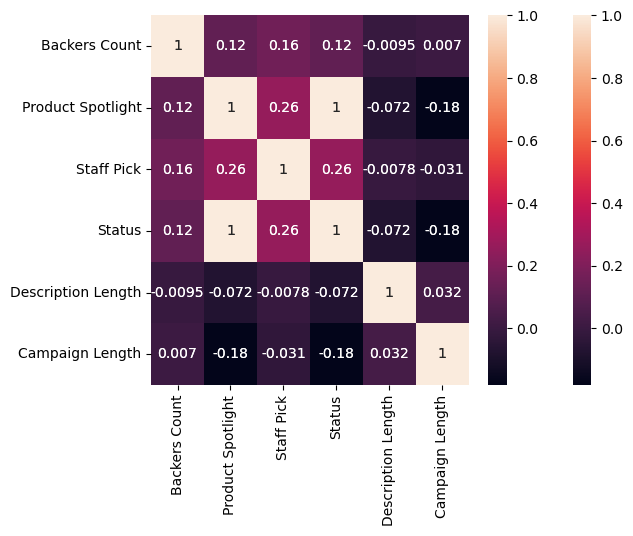

In [134]:
Var_Corr = df_sml.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)
plt.show()

# Modeling


In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, RandomizedSearchCV


In [89]:
# Establishing feature matrix and y vector.

target = 'Status'

X = df.drop(columns=target)
y = df[target]

print(X.shape)
print(y.shape)
print("The matrix and vector are the same length:", (len(y) == len(X)))

(148206, 21)
(148206,)
The matrix and vector are the same length: True


In [22]:
df.columns

NameError: name 'df' is not defined

In [7]:
dirty_df = raw_df[['category', 'created_at', 
                   'deadline', 'goal', 'launched_at', 
                   'state', 'staff_pick', 'spotlight', 
                   'country', 'blurb_length', 
                   'campaign_duration', 'sub_category']]

In [19]:
first = dirty_df['deadline'].max()
last = dirty_df['deadline'].min()
last - first

TypeError: unsupported operand type(s) for -: 'str' and 'str'